# 10-mins of Fame 18.02.2022
## OpenMM

In [4]:
import numpy as np
from sys import stdout
from matplotlib import pyplot as plt

from pdbfixer import PDBFixer #pdb preparation

import openmm as mm #openmm
from openmm import unit
import openmm.app as app

from rdkit import Chem
from rdkit.Chem import AllChem

import mdtraj as md #analysing trajectories

from openff.toolkit.topology import Molecule, Topology #generate forcefield parametres for ligand
from openmmforcefields.generators import GAFFTemplateGenerator

In [5]:
pdb_file = 'data/5r7y.pdb'
lig_name = 'JFM'
lig_smiles = 'CS(=O)(=O)NCCc1ccccc1'

### Prepare Protein

In [6]:
# clean up the original PDB file and add missing residues and heavy atoms
fixer = PDBFixer(pdb_file)


fixer.removeHeterogens()
fixer.findMissingResidues()

# only add missing residues in the middle of the chain, do not add terminal ones
chains = list(fixer.topology.chains())
keys = fixer.missingResidues.keys()
missingResidues = dict()
for key in keys:
    chain = chains[key[0]]
    if not (key[1] == 0 or key[1] == len(list(chain.residues()))):
        missingResidues[key] = fixer.missingResidues[key]
fixer.missingResidues = missingResidues

fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens()
prepared_protein = fixer

### Prepare Ligand

In [7]:
# split molecule
rdkit_mol = Chem.MolFromPDBFile(pdb_file)
rdkit_mol_split = Chem.rdmolops.SplitMolByPDBResidues(rdkit_mol)

# extract the ligand and remove any already present hydrogens
ligand = rdkit_mol_split[lig_name]
ligand = Chem.RemoveHs(ligand)

# assign bond orders from template
reference_mol = Chem.MolFromSmiles(lig_smiles)
prepared_ligand = AllChem.AssignBondOrdersFromTemplate(reference_mol, ligand)
prepared_ligand.AddConformer(ligand.GetConformer(0))

# protonate ligand
prepared_ligand = Chem.rdmolops.AddHs(prepared_ligand, addCoords=True)

### Merge Protein Ligand

#### Transform rdkit Object to openmm object

In [8]:
# convert RDKit to OpenFF
off_mol = Molecule.from_rdkit(prepared_ligand)

# add name for molecule
off_mol.name = lig_name

# add names for atoms
element_counter_dict = {}
for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
    element = rdkit_atom.GetSymbol()
    if element in element_counter_dict.keys():
        element_counter_dict[element] += 1
    else:
        element_counter_dict[element] = 1
    off_atom.name = element + str(element_counter_dict[element])

# convert from OpenFF to OpenMM
off_mol_topology = off_mol.to_topology()
mol_topology = off_mol_topology.to_openmm()
mol_positions = off_mol.conformers[0]

# convert units from Ångström to Nanometers
for atom in mol_positions:
    coords = atom / atom.unit
    atom = (coords / 10.0) * unit.nanometers  # since openmm works in nm

# combine topology and positions in modeller object
omm_mol = app.Modeller(mol_topology, mol_positions)

#### Merge Protein and Ligand

In [9]:
# combine topologies
md_protein_topology = md.Topology.from_openmm(prepared_protein.topology)  # using mdtraj for protein top
md_ligand_topology = md.Topology.from_openmm(omm_mol.topology)  # using mdtraj for ligand top
md_complex_topology = md_protein_topology.join(md_ligand_topology)  # add them together
complex_topology = md_complex_topology.to_openmm()

# combine positions
total_atoms = len(prepared_protein.positions) + len(omm_mol.positions)

# create an array for storing all atom positions as tupels containing a value and a unit
# called OpenMM Quantities
complex_positions = unit.Quantity(np.zeros([total_atoms, 3]), unit=unit.nanometers)
complex_positions[: len(prepared_protein.positions)] = prepared_protein.positions  # add protein positions
complex_positions[len(prepared_protein.positions) :] = omm_mol.positions  # add ligand positions

### Generate Forcefield
- [Which forcefield to choose?](http://docs.openmm.org/latest/userguide/application/02_running_sims.html#force-fields)
- [Generating forcefields](http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html)

In [10]:
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
if prepared_ligand is not None:
    gaff = GAFFTemplateGenerator(molecules=Molecule.from_rdkit(prepared_ligand, allow_undefined_stereo=True), )
    forcefield.registerTemplateGenerator(gaff.generator)

### Adding Hydrogens and Solvent to Model

In [11]:
# use app.Modeller to add hydrogens and solvent
modeller = app.Modeller(complex_topology, complex_positions)
modeller.addHydrogens(forcefield)
modeller.addSolvent(forcefield, model='tip3p', padding=1.0*unit.nanometers)
app.PDBFile.writeFile(modeller.topology, modeller.positions, open('5r7y_modeller_tip3p.pdb', 'w'))

### Preparing Intergrator and Running Simulation

In [9]:
# prepare system and integrator
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME,
    nonbondedCutoff=1.0*unit.nanometers, constraints=app.HBonds, rigidWater=True,
    ewaldErrorTolerance=0.0005)
integrator = mm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds,
    2.0*unit.femtoseconds)
integrator.setConstraintTolerance(0.00001)

# prepare simulation
simulation = app.Simulation(modeller.topology, system, integrator, )
simulation.context.setPositions(modeller.positions)

# minimize
print('Minimizing...')
simulation.minimizeEnergy()

# equilibrate for 100 steps
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
print('Equilibrating...')
simulation.step(100)

# append reporters
simulation.reporters.append(app.DCDReporter('trajectory_tip3p.dcd', 1000))
simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True,
    potentialEnergy=True, temperature=True, progress=True, remainingTime=True,
    speed=True, totalSteps=250000, separator='\t'))

# run 25 ns of production simulation
print('Running Production...')
simulation.step(250000)
print('Done!')

Minimizing...
Equilibrating...
Running Production...
#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
0.4%	1000	-1122755.932565367	274.0329673891064	0	--
0.8%	2000	-1101973.8735395619	293.98721070629415	7.05	1:41:17
1.2%	3000	-1095705.4426998866	297.890375633914	7.05	1:40:54
1.6%	4000	-1094151.5539369108	299.8767445937728	7.04	1:40:42
2.0%	5000	-1093504.1696920923	300.24883940670645	6.98	1:41:02
2.4%	6000	-1093681.4704212616	300.1507821102161	6.98	1:40:38
2.8%	7000	-1092740.2086221632	300.991021375209	6.97	1:40:25
3.2%	8000	-1092231.290890472	299.0251433735399	6.98	1:39:53
3.6%	9000	-1094262.6814351643	300.06699264222794	6.99	1:39:21
4.0%	10000	-1093738.8888940946	299.3486584274202	6.97	1:39:14
4.4%	11000	-1094696.9647389646	301.1928659607359	6.95	1:39:03
4.8%	12000	-1095874.3320949215	299.80098222736564	6.92	1:39:03
5.2%	13000	-1096276.5572477067	299.02792791965885	6.9	1:38:51
5.6%	14000	-1095557.5841953051	300.322983914261	6.9	1:

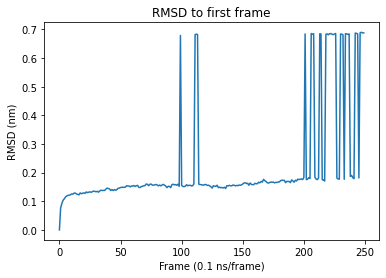

In [14]:
traj  = md.load_dcd('trajectory_tip3p.dcd', '5r7y_modeller_tip3p.pdb')
traj = traj.atom_slice(traj.top.select(f'protein or resname {lig_name}'))

# calculate RMSD to first frame and plot figure
rmsd = md.rmsd(traj, traj)

plt.figure()
plt.plot(rmsd)
plt.title('RMSD to first frame')
plt.xlabel('Frame (0.1 ns/frame)')
plt.ylabel('RMSD (nm)')
plt.savefig('rmsd.png', dpi=300)
plt.show()
plt.close()

### Sources
- https://openmm.org/tutorials
- https://projects.volkamerlab.org/teachopencadd/talktorials/T019_md_simulation.html 

## PyMol

- PyMOL is a free 3D graphics software used to display biomolecules in biochemistry and bioinformatics. 
- Most important rescource: [PyMolWiki](https://pymolwiki.org/index.php/Main_Page)
- Since PyMol is based on Python, it is relatively easy to write scripts for PyMol.
- Scripting in general:
    1. Define a function in python
    2. Add `cmd.extend("doSimpleThing",doSimpleThing)` to python script
    3. Run python script in PyMol command line: `run mySampleScript.py`
    4. Now all extended functions are available (`doSimpleThing`)
- All commands in pymol are available over the cmd function `from pymol import cmd`
- The stored array can be used to get data from PyMol into our script `from pymol import stored`

### Sources
- https://pymolwiki.org/index.php/Simple_Scripting